## Crypto Token Correlation Heatmap

### Importing Relevant Liberies/Modules

In [ ]:
import os
import json
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from dotenv import load_dotenv
from datetime import datetime
import joblib

load_dotenv()  # ✅ Now you can call it



True

### Fetching 30-Day Bitcoin Market Chart Data from CoinGecko API

In [ ]:
# Load CoinGecko API key from environment variables (.env file)
api_key = os.getenv("GECKO_API")  # ✅ Ensure the key in .env matches this variable name

# Define query parameters
coin_id = "bitcoin"   # The cryptocurrency to fetch (can be changed dynamically)
vs_currency = "usd"   # The currency to compare against
days = "30"           # Number of days of historical data to retrieve

# Base URL for CoinGecko Pro API's market chart endpoint
url = f"https://pro-api.coingecko.com/api/v3/coins/{coin_id}/market_chart"

# Request parameters sent to the API
params = {
    "vs_currency": vs_currency,
    "days": days
}

# Headers including API key authentication
headers = {
    "accept": "application/json",  # Expect JSON response
    "x-cg-pro-api-key": api_key    # Authenticate with CoinGecko Pro
}

# Send GET request to the API
response = requests.get(url, headers=headers, params=params)

# Print raw JSON response as text for inspection/debugging
print(response.text)


{"prices":[[1752307442173,117752.86079185014],[1752311006298,117881.05769359317],[1752314646475,118143.01873929753],[1752318216450,118110.58284934341],[1752321659711,117835.46100136574],[1752325434563,117515.67059179093],[1752329015449,117476.30745219445],[1752332643192,117407.79634237713],[1752336231898,117143.94989455283],[1752339794979,117217.26827976393],[1752343432894,117486.51528697932],[1752346830432,117461.63124883146],[1752350608184,117579.57730036778],[1752354053556,117174.73758068673],[1752357842329,117476.84026613204],[1752361398381,117404.65973254917],[1752365018740,117413.3981640852],[1752368449876,117379.69191559301],[1752372228383,117599.4768804533],[1752375838696,117668.14079146368],[1752379415586,117791.73467477878],[1752383001225,117915.60410052535],[1752386626800,117774.65876383883],[1752390218831,117941.35491893676],[1752393797031,117996.74076472051],[1752397410180,117826.07471071987],[1752400997843,117784.45716105598],[1752404608557,117789.85826913697],[1752408029

 ### Convert CoinGecko Price Data to a Pandas DataFrame

In [ ]:
# Parse JSON response from the API into a Python dictionary
data = response.json()

# Create a DataFrame from the 'prices' list in the API response
# Each entry in 'prices' is a [timestamp, price] pair
df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])

# Convert Unix timestamp (in milliseconds) to a human-readable datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set 'timestamp' column as the DataFrame index for time-series operations
df.set_index('timestamp', inplace=True)

# Display the first 20 rows of the DataFrame
print(df.head(20))


                                 price
timestamp                             
2025-07-12 08:04:02.173  117752.860792
2025-07-12 09:03:26.298  117881.057694
2025-07-12 10:04:06.475  118143.018739
2025-07-12 11:03:36.450  118110.582849
2025-07-12 12:00:59.711  117835.461001
2025-07-12 13:03:54.563  117515.670592
2025-07-12 14:03:35.449  117476.307452
2025-07-12 15:04:03.192  117407.796342
2025-07-12 16:03:51.898  117143.949895
2025-07-12 17:03:14.979  117217.268280
2025-07-12 18:03:52.894  117486.515287
2025-07-12 19:00:30.432  117461.631249
2025-07-12 20:03:28.184  117579.577300
2025-07-12 21:00:53.556  117174.737581
2025-07-12 22:04:02.329  117476.840266
2025-07-12 23:03:18.381  117404.659733
2025-07-13 00:03:38.740  117413.398164
2025-07-13 01:00:49.876  117379.691916
2025-07-13 02:03:48.383  117599.476880
2025-07-13 03:03:58.696  117668.140791


### Fetch and Combine Hourly Cryptocurrency Prices from CoinGecko

In [37]:
def fetch_hourly_price_data(coin_ids, vs_currency='usd', days='30'):
    """
    Fetch hourly price data for multiple cryptocurrencies from the CoinGecko API.

    Args:
        coin_ids (list): List of CoinGecko coin IDs (e.g., ["bitcoin", "ethereum"]).
        vs_currency (str): The target currency (default: 'usd').
        days (str): Number of past days to retrieve (e.g., '30').

    Returns:
        pd.DataFrame: Combined DataFrame with hourly prices for all specified coins.
    """
    
    base_url = "https://pro-api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    price_dfs = []  # Store DataFrames for each coin

    for coin_id in coin_ids:
        # Format URL for each specific coin
        url = base_url.format(coin_id=coin_id)

        # Request parameters
        params = {
            'vs_currency': vs_currency,
            'days': days,
            # 'interval': 'hourly'  # Optional: Uncomment to force hourly data
        }

        # API request headers (with API key from .env)
        headers = {
            "accept": "application/json",
            "x-cg-pro-api-key": os.getenv("GECKO_API")
        }

        # Send GET request to API and raise error if unsuccessful
        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status()

        # Parse JSON response into DataFrame
        data = response.json()
        df = pd.DataFrame(data['prices'], columns=['timestamp', coin_id])

        # Convert timestamp to datetime and set as index
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Resample to hourly data (last available price each hour)
        df = df.resample('1h').last()

        # Add this coin's DataFrame to list
        price_dfs.append(df)

    # Combine all coin DataFrames side-by-side into one DataFrame
    result_df = pd.concat(price_dfs, axis=1)

    return result_df


###  Fetch, Store, and Save Hourly Crypto Price Data

In [39]:
# List of cryptocurrency tokens to fetch
tokens = ['bitcoin', 'ethereum', 'solana']

# Fetch hourly price data for the last 30 days
df_prices = fetch_hourly_price_data(tokens, days='30')

# Directory to save the dataset
save_dir = "C:\\Users\\g\\OneDrive\\Documents\\Crypto Correlation heatmap\\Project\\Database"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save DataFrame as a serialized .pkl file using joblib
joblib.dump(df_prices, os.path.join(save_dir, "crypto_prices.pkl"))

# Display the first 20 rows of the DataFrame
print(df_prices.tail(20))


                           bitcoin     ethereum      solana
timestamp                                                  
2025-08-10 14:00:00  118525.120584  4175.734323  179.264802
2025-08-10 15:00:00  118769.181170  4221.119286  181.465952
2025-08-10 16:00:00  118850.974365  4220.438984  181.405684
2025-08-10 17:00:00  118651.237064  4232.331189  181.987091
2025-08-10 18:00:00  118529.324741  4231.116330  181.817920
2025-08-10 19:00:00  118544.258542  4233.214746  182.682189
2025-08-10 20:00:00  118667.491069  4249.435771  182.997991
2025-08-10 21:00:00  118199.182863  4198.898954  182.299246
2025-08-10 22:00:00  118706.009479  4218.609404  183.220998
2025-08-10 23:00:00  119034.739530  4238.311728  182.996974
2025-08-11 00:00:00  119248.448278  4250.615963  182.689286
2025-08-11 01:00:00  119164.919526  4270.084080  181.682095
2025-08-11 02:00:00  119884.435712  4305.958604  183.754941
2025-08-11 03:00:00  121778.220387  4305.950472  185.076226
2025-08-11 04:00:00  121768.139586  4309

### Fetch Hourly Price Data from CoinGecko API

In [ ]:
# === Function: Fetch Hourly Price Data from CoinGecko API ===
def fetch_hourly_price_data(coin_ids, vs_currency='usd', days='30'):
    # Base API endpoint for CoinGecko
    base_url = "https://pro-api.coingecko.com/api/v3/coins"
    price_dfs = []  # List to store DataFrames for each coin

    for coin_id in coin_ids:
        # Build full API URL for the specific coin
        url = f"{base_url}/{coin_id}/market_chart"

        # Query parameters
        params = {
            'vs_currency': vs_currency,  # Currency to compare against (e.g., USD)
            'days': days  # Number of past days to fetch
        }

        # Headers with API key for authentication
        headers = {
            "accept": "application/json",
            "x-cg-pro-api-key": os.getenv("GECKO_API")
        }

        # Send API request
        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status()  # Stop if the request failed
        data = response.json()  # Parse JSON response

        # Convert 'prices' data into a DataFrame
        df = pd.DataFrame(data['prices'], columns=['timestamp', coin_id])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert to datetime
        df.set_index('timestamp', inplace=True)  # Set timestamp as index
        df = df.resample('1h').last()  # Resample to hourly intervals, keeping last price

        price_dfs.append(df)  # Store DataFrame in list

    # Combine all coin DataFrames into one table
    result_df = pd.concat(price_dfs, axis=1)
    return result_df


### Fetch, Save, and Display Crypto Price Data

In [ ]:

# List of tokens to fetch (CoinGecko IDs)
tokens = ['bitcoin', 'ethereum', 'solana']

# Fetch the last 30 days of hourly price data for the tokens
df_prices = fetch_hourly_price_data(tokens, days='30')

# Directory to save the serialized DataFrame
save_dir = "C:\\Users\\g\\OneDrive\\Documents\\Crypto Correlation heatmap\\Project\\Database"
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

# Save DataFrame as a .pkl file using joblib for quick loading later
joblib.dump(df_prices, os.path.join(save_dir, "crypto_prices.pkl"))

# Display the first 5000 rows in the console
print(df_prices.head(5000))


                           bitcoin     ethereum      solana
timestamp                                                  
2025-07-12 10:00:00  118143.018739  2974.501599  162.661403
2025-07-12 11:00:00  118110.582849  2976.645637  162.999535
2025-07-12 12:00:00  117835.461001  2967.511257  161.911202
2025-07-12 13:00:00  117515.670592  2937.877206  159.901606
2025-07-12 14:00:00  117476.307452  2936.477208  159.426698
...                            ...          ...         ...
2025-08-11 05:00:00  122019.473515  4323.429446  185.918937
2025-08-11 06:00:00  122002.445325  4302.471904  185.247724
2025-08-11 07:00:00  122227.469335  4299.852991  184.704425
2025-08-11 08:00:00  121429.253212  4266.546971  182.735577
2025-08-11 09:00:00  121255.975160  4270.055205  183.617395

[720 rows x 3 columns]


### Correlation Heatmap: Crypto Price Relationships

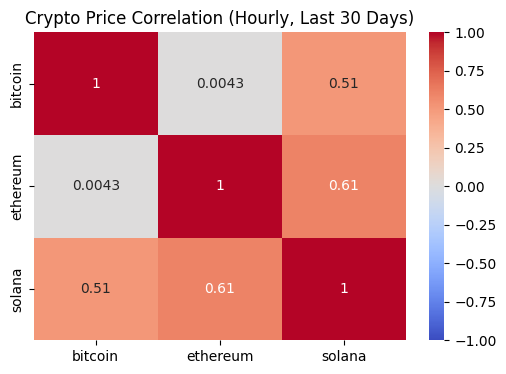

In [ ]:
# Remove any rows that contain NaN values to ensure valid correlation calculation
df_prices_clean = df_prices.dropna()

# Import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix for the cleaned DataFrame
corr = df_prices_clean.corr()

# Create a heatmap figure
figura = plt.figure(figsize=(6, 4))
sns.heatmap(
    corr, 
    annot=True,      # Show correlation values on the heatmap
    cmap="coolwarm", # Color scale: red (negative) to blue (positive)
    vmin=-1, vmax=1  # Fix range for correlation values
)
plt.title("Crypto Price Correlation (Hourly, Last 30 Days)")
plt.show()


### Price Volatity

In [19]:
import numpy as np

# Compute hourly returns
returns = df_prices.pct_change().dropna()

# Compute volatility (std dev of returns)
volatility = returns.std() * np.sqrt(24*30)  # Annualize to 30 days of hourly data

# Show results
print("Price Volatility (30-day, annualized):")
print(volatility.sort_values(ascending=False))


Price Volatility (30-day, annualized):
solana      0.190539
ethereum    0.169522
bitcoin     0.081398
dtype: float64


In [20]:
print(returns.head())

                      bitcoin  ethereum    solana
timestamp                                        
2025-07-12 09:00:00  0.001089  0.000154 -0.003451
2025-07-12 10:00:00  0.002222  0.003169  0.001085
2025-07-12 11:00:00 -0.000275  0.000721  0.002079
2025-07-12 12:00:00 -0.002329 -0.003069 -0.006677
2025-07-12 13:00:00 -0.002714 -0.009986 -0.012412


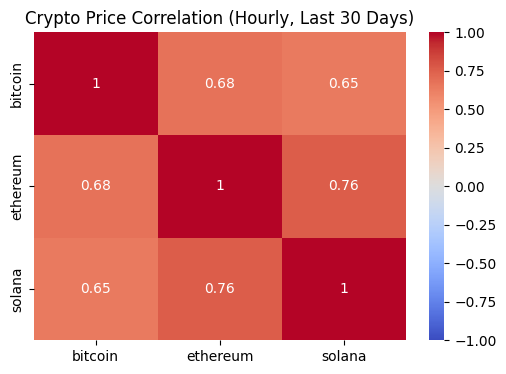

In [21]:
corr = returns.corr()

figura = plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Crypto Price Correlation (Hourly, Last 30 Days)")
plt.show()


### Crypto Price Data Fetcher & Correlation Heatmap

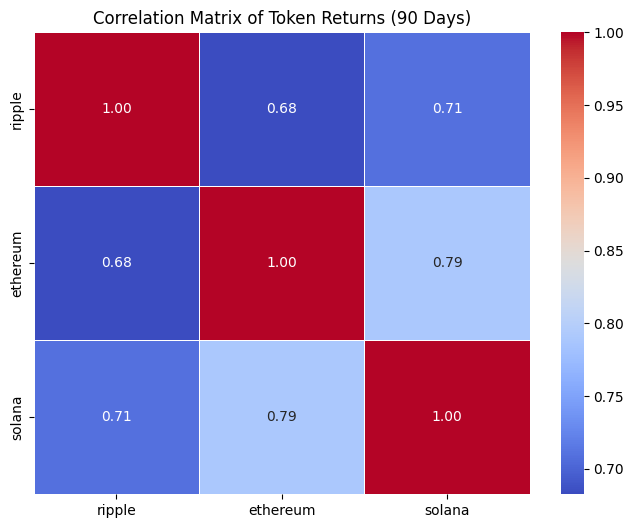

In [43]:
def fetch_hourly_price_data(coin_ids, vs_currency='usd', days='90'):
    """
    Fetch hourly price data for multiple tokens from the CoinGecko API.
    
    Args:
        coin_ids (list): List of token IDs (e.g., ['bitcoin', 'ethereum']).
        vs_currency (str): Target currency (default: 'usd').
        days (str): Number of past days to fetch data for (e.g., '30', '90').

    Returns:
        pd.DataFrame: Hourly price data for the requested tokens.
    """
    base_url = "https://pro-api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    headers = {
        "accept": "application/json",
        "x-cg-pro-api-key": os.getenv("GECKO_API")  # API key from .env
    }

    all_data = pd.DataFrame()

    for coin_id in coin_ids:
        url = base_url.format(coin_id=coin_id)
        params = {
            "vs_currency": vs_currency,
            "days": days
        }

        # Send GET request to API
        response = requests.get(url, params=params, headers=headers)

        # If request fails, skip this token
        if response.status_code != 200:
            print(f"Failed to fetch {coin_id}: {response.text}")
            continue

        # Parse JSON and convert to DataFrame
        data = response.json()
        df = pd.DataFrame(data['prices'], columns=['timestamp', coin_id])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Resample to hourly frequency (last recorded price in each hour)
        df = df.resample('1h').last()

        # Merge into main DataFrame
        if all_data.empty:
            all_data = df
        else:
            all_data = all_data.join(df, how='outer')

    return all_data

# --- User input for tokens ---
tokens_input = input("Enter token IDs separated by commas (e.g., bitcoin,ethereum,solana): ")
tokens = [t.strip() for t in tokens_input.split(",") if t.strip()]

# Fetch price data
df_prices = fetch_hourly_price_data(tokens, days='90')

# Drop rows with missing values
df_prices_clean = df_prices.dropna()

# Calculate hourly returns
returns = df_prices_clean.pct_change().dropna()

# Calculate annualized volatility (based on 90 days)
volatility = returns.std() * np.sqrt(24 * 90)

# Calculate correlation matrix
correlation_matrix = returns.corr()

# --- Plot correlation heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Matrix of Token Returns (90 Days)")
plt.show()
